# Прогнозирование входящего трафика магазинов


## 0. Входные данные

Наш клиент (продуктовая сеть) хочет прогнозировать входящий трафик на месяц вперед с детализацией по часу. Мы запросили исторические данные за полтора года и клиент их прислал. 
#### В рамках задания необходимо:

1. сделать мини анализ данных
2. предложить вариант, как сделать прогноз количества входящих
3. выбрать метрику для оценки качества
4. Необязательное: спрогнозировать количество входящих на декабрь 2019 года 

**Основная цель задания** -- продемонстрировать навыки обработки информации / знание методов прогнозирования, умение оформлять ноутбуки. Второстепенная задача это точность прогноза.

#### Данные в архиве:
1. data/shop_traffic/train.xlsx
2. data/shop_traffic/test.xlsx

## 1. Постановка цели проекта

**Цель проекта:** Построить модель, которая будет предсказывать трафик магазина по часам по текушим данным на следующий месяц

## 2. Загрузка данных

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
%matplotlib inline

pd.options.display.max_columns = None

In [146]:
train_df = pd.read_excel('data/train.xlsx')
test_df = pd.read_excel('data/test.xlsx')

n_train = train_df.shape[0]
n_test = test_df.shape[0]

print(f"Train rows: {n_train}, Test rows: {n_test}")

train_df

Train rows: 15612, Test rows: 901


,Unnamed: 0,Номер магазина,dt_h_open,Количество вошедших,weekday,day,month,year,hour,weekday_number_in_month
0,831,Алтушка,2018-03-01 08:00:00,5,3,1,3,2018,8,0
1,11830,Бутово,2018-03-01 08:00:00,63,3,1,3,2018,8,0
2,832,Алтушка,2018-03-01 09:00:00,33,3,1,3,2018,9,0
3,11831,Бутово,2018-03-01 09:00:00,55,3,1,3,2018,9,0
4,833,Алтушка,2018-03-01 10:00:00,63,3,1,3,2018,10,0
...,...,...,...,...,...,...,...,...,...,...
15607,21040,Бутово,2019-11-30 20:00:00,83,5,30,11,2019,20,4
15608,10116,Алтушка,2019-11-30 20:00:00,109,5,30,11,2019,20,4
15609,21041,Бутово,2019-11-30 21:00:00,75,5,30,11,2019,21,4
15610,10117,Алтушка,2019-11-30 21:00:00,65,5,30,11,2019,21,4


## 3. Подготовка данных

### Анализ данных

На первый взгляд мы видим следующее:
- Значения в столбеце **Unnamed: 0** монотонны (по магазинам) и различны. Надо это проверить
- В **Номер магазина** видим только 2 значения - видимо у нас данные только по 2м магазинам
- Столбец **dt_h_open** представляет собой ежечасный ряд. Будем удобно использовать его в качестве индекса
- **Количество вошедших** - наш target столбец
- Оставшиеся столбцы представляют собой просто части из нашей даты

Проведем анализ по столбцам подробнее

#### Столбец 'Unnamed: 0'

In [147]:
def check_unique(col, mark):
    count_of_non_unique = len(col) - col.nunique()
    print(f"{mark}: Count of non unique values in '{col.name}': {count_of_non_unique}")
    return count_of_non_unique

check_unique(train_df['Unnamed: 0'], "train")
check_unique(test_df['Unnamed: 0'], "test")

train: Count of non unique values in 'Unnamed: 0': 0
test: Count of non unique values in 'Unnamed: 0': 0


0

Все значения в колонке 'Unnamed: 0' уникальны => по всей видимости это id записи. Удалим их

In [148]:
test_df = test_df.drop(columns= ['Unnamed: 0'])
train_df = train_df.drop(columns= ['Unnamed: 0'])

#### Столбец 'Номер магазина'

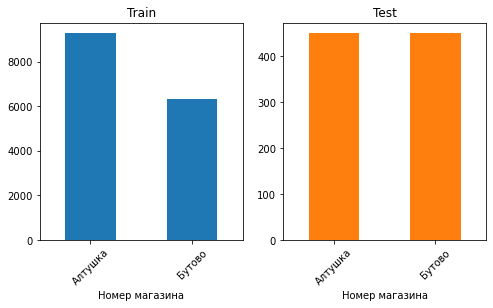

In [149]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

train_df.groupby('Номер магазина').size().plot(kind='bar',ax=axes[0], title='Train', color='tab:blue')
test_df.groupby('Номер магазина').size().plot(kind='bar',ax=axes[1], title='Test', color='tab:orange')

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.show()

Из графиков видно, что данные нам представлены по 2м магазинам, находящимся в разных концах Москвы.
Возникает предположение, что их надо расматривать независимо от друг друга

Также видно, что у нас есть неравномерноть тренировочных и тестовых данных. Данный факт необходимо будет учесть при построении модели

In [150]:
train_df_alt = train_df[train_df['Номер магазина'] == 'Алтушка']
train_df_but = train_df[train_df['Номер магазина'] == 'Бутово']

test_df_alt = test_df[test_df['Номер магазина'] == 'Алтушка']
test_df_but = test_df[test_df['Номер магазина'] == 'Бутово']

train_df_alt.head()

,Номер магазина,dt_h_open,Количество вошедших,weekday,day,month,year,hour,weekday_number_in_month
0,Алтушка,2018-03-01 08:00:00,5,3,1,3,2018,8,0
2,Алтушка,2018-03-01 09:00:00,33,3,1,3,2018,9,0
4,Алтушка,2018-03-01 10:00:00,63,3,1,3,2018,10,0
7,Алтушка,2018-03-01 11:00:00,65,3,1,3,2018,11,0
9,Алтушка,2018-03-01 12:00:00,63,3,1,3,2018,12,0


#### Столбец 'dt_h_open'

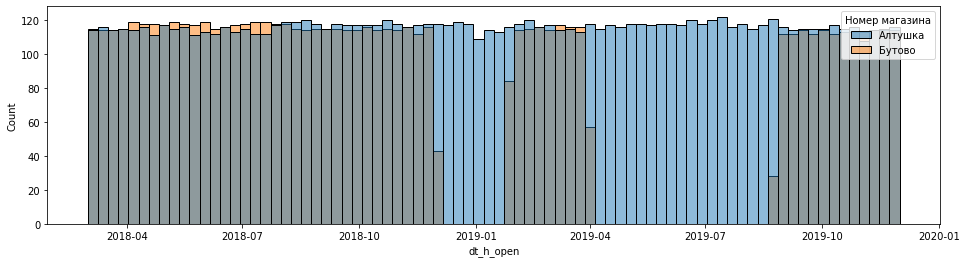

In [151]:
fig, ax = plt.subplots(figsize=(16,4))
ax = sns.histplot(data=train_df, x="dt_h_open", hue="Номер магазина", ax=ax, bins=80)

Видим, что есть пропуски в данных для магазина из Бутово. Надо будет учесть данный факт при построении модели

По описанию задачи наши данные представляют собой временной ряд c шагом 1 час. Проверим, что они все уникальны по магазинам.

In [152]:
check_unique(train_df_alt['dt_h_open'], 'Алтушка')
check_unique(train_df_but['dt_h_open'], 'Бутово')

Алтушка: Count of non unique values in 'dt_h_open': 0
Бутово: Count of non unique values in 'dt_h_open': 0


0

Будет удобно сделать столбец 'dt_h_open' индексом и отсортировать по нему. Также заресэплим с шагом 1 час. Так у нас будет больше записей, но на каждый час будет запись, в том числе на ночные часы, на которые записей нет. Это поможет нам при построении модели

In [153]:
train_df_alt = train_df_alt.set_index('dt_h_open').resample('1H').mean().fillna(0).sort_index()
train_df_but = train_df_but.set_index('dt_h_open').resample('1H').mean().fillna(0).sort_index()

In [154]:
train_df_alt.head()

,Количество вошедших,weekday,day,month,year,hour,weekday_number_in_month
dt_h_open,,,,,,,
2018-03-01 08:00:00,5.0,3.0,1.0,3.0,2018.0,8.0,0.0
2018-03-01 09:00:00,33.0,3.0,1.0,3.0,2018.0,9.0,0.0
2018-03-01 10:00:00,63.0,3.0,1.0,3.0,2018.0,10.0,0.0
2018-03-01 11:00:00,65.0,3.0,1.0,3.0,2018.0,11.0,0.0
2018-03-01 12:00:00,63.0,3.0,1.0,3.0,2018.0,12.0,0.0


#### Столбец 'Количество вошедших' (target столбец)

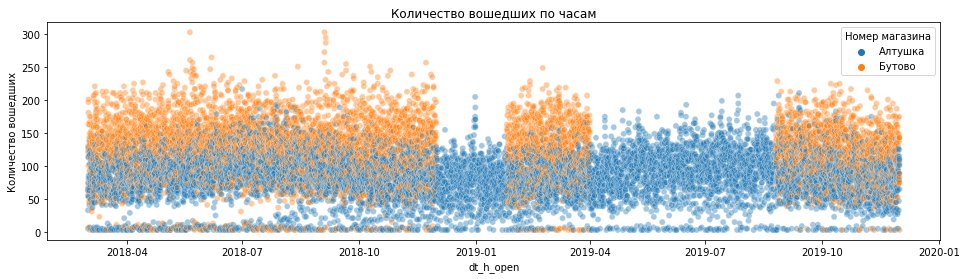

In [155]:
fig, ax = plt.subplots(figsize=(16,4))
ax = sns.scatterplot(data=train_df, x="dt_h_open", y="Количество вошедших", hue="Номер магазина", ax=ax, alpha=0.4)
t = ax.set_title("Количество вошедших по часам")

Найдем промежутки, когда у нас не было данных для магазина из Бутово. По графику видно, что это 2 промежутка - один до 2019-03-01, другой после

In [156]:
def find_range_without_data(df):
    df_without_data = df[df['Количество вошедших'] == 0]
    start_date = df_without_data.index[0]
    end_date = df_without_data.index[-1]
    
    print(f"Range without data: [{start_date}..{end_date}]")
    
train_df_by_days_but = train_df_but.resample('1D').sum()

find_range_without_data(train_df_by_days_but[:'2019-03-01'])
find_range_without_data(train_df_by_days_but['2019-03-01':])

Range without data: [2018-12-01 00:00:00..2019-01-24 00:00:00]
Range without data: [2019-04-01 00:00:00..2019-08-24 00:00:00]


#### Тренд и сезонность

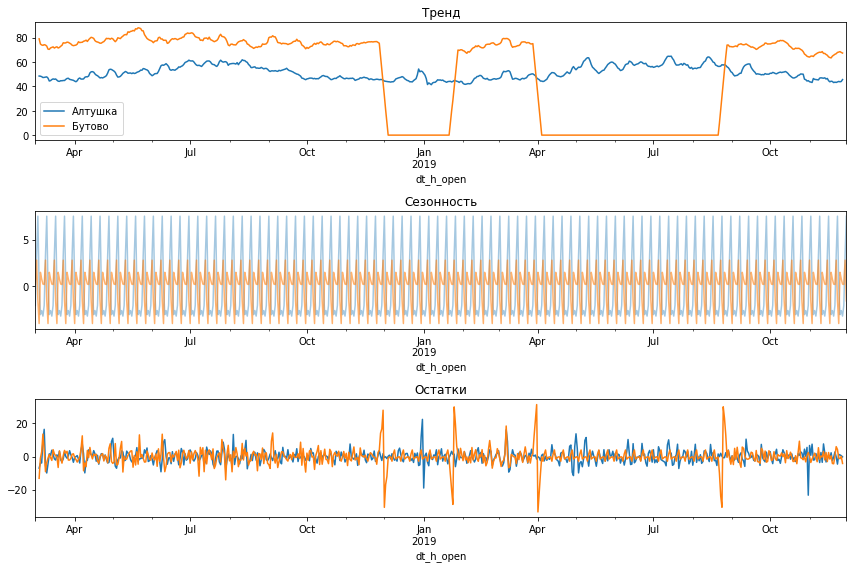

In [157]:
train_df_by_days_mean_alt = train_df_alt.resample('1D').mean()
train_df_by_days_mean_but = train_df_but.resample('1D').mean()

decomposed_alt = seasonal_decompose(train_df_by_days_mean_alt["Количество вошедших"])
decomposed_but = seasonal_decompose(train_df_by_days_mean_but["Количество вошедших"])

plt.figure(figsize=(12, 8))

plt.subplot(311)
decomposed_alt.trend.plot(ax=plt.gca(),label='Алтушка')
decomposed_but.trend.plot(ax=plt.gca(),label='Бутово')
plt.title('Тренд')
plt.legend()

plt.subplot(312)
decomposed_alt.seasonal.plot(ax=plt.gca(),alpha=0.4,label='Алтушка')
decomposed_but.seasonal.plot(ax=plt.gca(),alpha=0.6,label='Бутово')
plt.title('Сезонность')

plt.subplot(313)
decomposed_alt.resid.plot(ax=plt.gca(),label='Алтушка')
decomposed_but.resid.plot(ax=plt.gca(),label='Бутово')
plt.title('Остатки')

plt.tight_layout()

По графику тренда видно, что:
- Алтуфьево: тренд стационарный, видна периодичность - летом спрос повышается
- Бутово: тренд также имеет очертания периодичности, можно предположить, что в отсутствующи промежутках трафик примерно похож на трафик другого магазина

График сезонности не информативен, построем его в меньшем масштабе

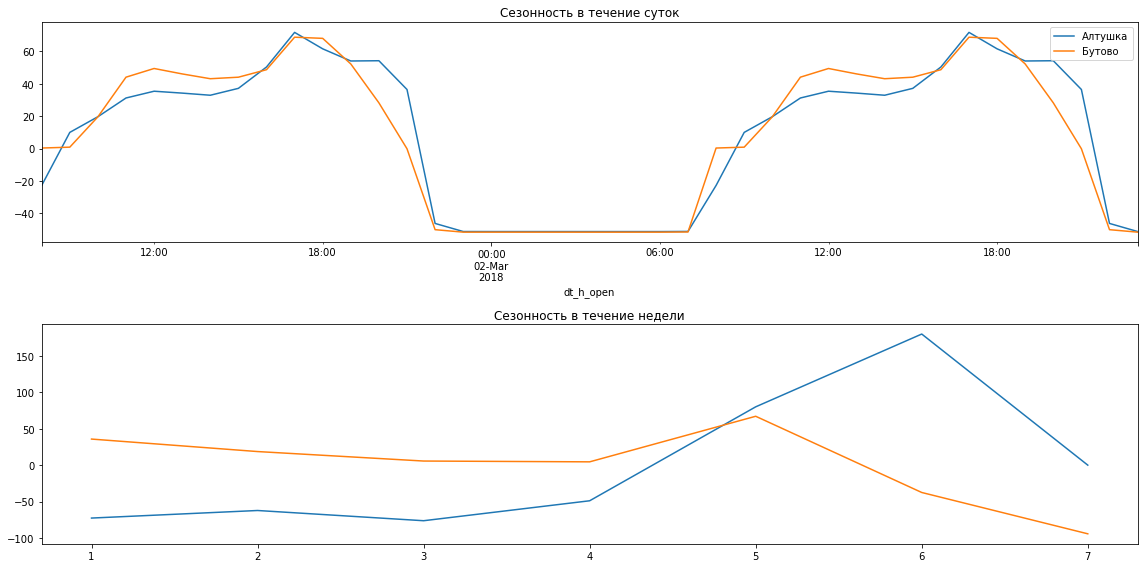

Алтушка: Среднее кол-во людей в день: 1227
Бутово: Среднее кол-во людей в день: 1237


In [158]:
# В течение суток
decomposed_alt = seasonal_decompose(train_df_alt["Количество вошедших"])
decomposed_but = seasonal_decompose(train_df_but["Количество вошедших"])

plt.figure(figsize=(16, 8))

plt.subplot(211)
decomposed_alt.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(), label='Алтушка')
decomposed_but.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(), label='Бутово')

plt.title('Сезонность в течение суток')
plt.legend()


# В течение недели
traffic_by_days_sum_alt = train_df_alt.resample('1D')["Количество вошедших"].sum()
traffic_by_days_sum_but = train_df_but.resample('1D')["Количество вошедших"].sum()

decomposed_alt = seasonal_decompose(traffic_by_days_sum_alt)
decomposed_but = seasonal_decompose(traffic_by_days_sum_but)

plt.subplot(212)

# 2018-03-05 - пн, 2018-03-11
plt.plot(range(1,8), decomposed_alt.seasonal['2018-03-05':'2018-03-11'].values, label='Алтушка')
plt.plot(range(1,8), decomposed_but.seasonal['2018-03-05':'2018-03-11'].values, label='Бутово')

plt.title('Сезонность в течение недели')

plt.tight_layout()
plt.show()

print(f"Алтушка: Среднее кол-во людей в день: {traffic_by_days_sum_alt.mean():.0f}")
print(f"Бутово: Среднее кол-во людей в день: {traffic_by_days_sum_but.mean():.0f}")

- **По графику сезонности в течение суток** можно отметить, что наибольшее количество посетилей приходит в районе 17-18 часов, также наблюдается локальный максимум днем, в районе 12 часов. В магазине из Бутово он более ярко выражен
- **По графику сезонности в течение недели** можно увидеть, что паттерны магазинов разные:
 - Алтуфьево: спрос пн-чт немного ниже среднего и повышается в пт-сб
 - Бутово: спрос в течение недели примерно средний

### Очистка данных
(Обработка выбросов и пропусков)

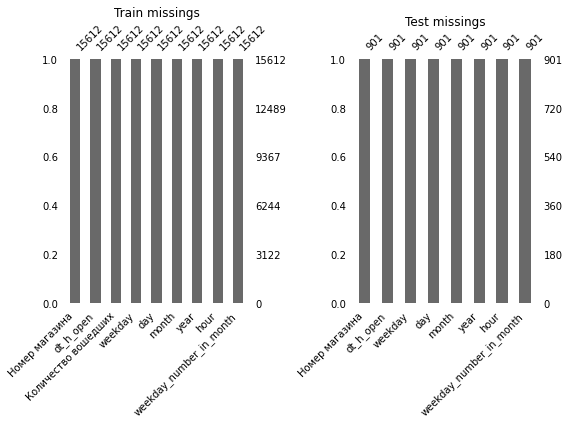

In [159]:
fig, [ax_train, ax_test] = plt.subplots(1, 2, figsize=(8,6))

msno.bar(train_df, ax=ax_train, fontsize=10)
ax_train.set_title('Train missings')

msno.bar(test_df, ax=ax_test, fontsize=10)
ax_test.set_title('Test missings')

fig.tight_layout()

Данные хорошие, пропущенных значений нет

### Преобразование данных
(Добавление признаков из других источников, разложение признаков на несколько признаков)

Так как у нас нет части данных для магазина из Бутово, то пока что продолжим решать задачу только для магазина из Алтуфьево и позже сделаем тоже самое для магазина из Бутово

#### Заполнение пропусков

In [160]:
train_df_alt['2018-03-01 23:00:00':].head()

,Количество вошедших,weekday,day,month,year,hour,weekday_number_in_month
dt_h_open,,,,,,,
2018-03-01 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-02 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-02 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-02 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Видим, что после ресеплинга у нас есть пропуски в данных. Возьмем все данные из даты

In [161]:
def week_number_of_month(date_values):
    return pd.Series(date_values).apply(lambda d: \
        d.isocalendar()[1] - d.replace(day=1).isocalendar()[1]
    ).values

def fix_date_features(df):
    df['weekday'] = df.index.dayofweek
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['hour'] = df.index.hour
    df['weekday_number_in_month'] = week_number_of_month(df.index.values)
    
fix_date_features(train_df_alt)

#### Дополнения признаками

Дополним наши данные дифференциалами: добавим разность значений, отстающие значения до **max_lag** и скользящее среднее и скользящее стандартное отклонение размера **rolling_size**

In [162]:
train_df_alt

,Количество вошедших,weekday,day,month,year,hour,weekday_number_in_month
dt_h_open,,,,,,,
2018-03-01 08:00:00,5.0,3,1,3,2018,8,0
2018-03-01 09:00:00,33.0,3,1,3,2018,9,0
2018-03-01 10:00:00,63.0,3,1,3,2018,10,0
2018-03-01 11:00:00,65.0,3,1,3,2018,11,0
2018-03-01 12:00:00,63.0,3,1,3,2018,12,0
...,...,...,...,...,...,...,...
2019-11-30 17:00:00,125.0,5,30,11,2019,17,4
2019-11-30 18:00:00,111.0,5,30,11,2019,18,4
2019-11-30 19:00:00,101.0,5,30,11,2019,19,4


In [163]:
train_df_alt_copy = train_df_alt.copy()

In [164]:
train_df_alt = train_df_alt_copy.copy()

def make_new_features(df, max_lag, rolling_size):
    df['diff'] = abs(df['Количество вошедших'] - df['Количество вошедших'].shift())
    
    for i in range(1, max_lag + 1):
        df['lag_' + str(i)] = df['Количество вошедших'].shift(i)
        
    df['rolling_mean'] = df['Количество вошедших'].shift().rolling(rolling_size).mean()
    df['rolling_std'] = df['Количество вошедших'].shift().rolling(rolling_size).std()

make_new_features(train_df_alt, 3, 24)

train_df_alt.fillna(0, inplace=True)

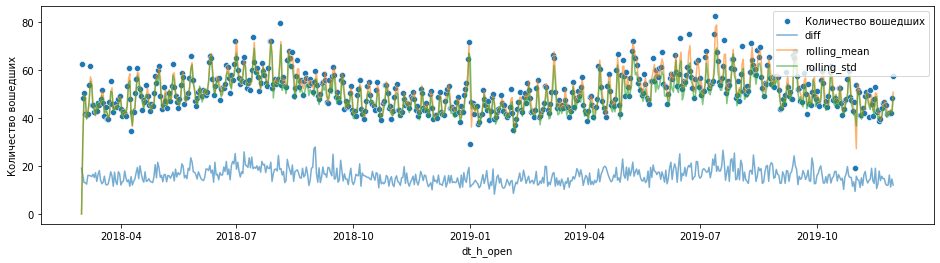

In [165]:
train_df_by_days_alt = train_df_alt.resample('1D').mean()

fig, ax = plt.subplots(figsize=(16,4))
ax = sns.scatterplot(data=train_df_by_days_alt, x="dt_h_open", y="Количество вошедших", ax=ax, label='Количество вошедших')
sns.lineplot(data=train_df_by_days_alt, x="dt_h_open", y="diff", ax=ax, label='diff', alpha=0.6)
sns.lineplot(data=train_df_by_days_alt, x="dt_h_open", y="rolling_mean", ax=ax, label='rolling_mean', alpha=0.6)
sns.lineplot(data=train_df_by_days_alt, x="dt_h_open", y="rolling_std", ax=ax, label='rolling_std', alpha=0.6)
plt.legend(loc='upper right')

## 4. Построение модели

### Выбор модели

#### XGBRegressor

In [166]:
from sklearn.metrics import mean_absolute_error
def check_score(y_pred, y_true):
    return mean_absolute_error(y_pred, y_true)

### Подготовка данных для модели
(Разделение на train-valid-test, scaling, encoding)

In [167]:
train_valid_data, test_data = train_test_split(train_df_alt, shuffle=False, test_size=24*30)
train_data, valid_data = train_test_split(train_valid_data,  shuffle=False, test_size=24*30)

X_train_valid = train_valid_data.drop(['Количество вошедших'], axis=1)
X_train = train_data.drop(['Количество вошедших'], axis=1)
X_valid = valid_data.drop(['Количество вошедших'], axis=1)
X_test = test_data.drop(['Количество вошедших'], axis=1)

y_train_valid = train_valid_data['Количество вошедших']
y_train = train_data['Количество вошедших']
y_valid = valid_data['Количество вошедших']
y_test = test_data['Количество вошедших']

print(f"Train size: {train_data.shape}")
print(f"Valid size: {valid_data.shape}")
print(f"Test size:  {test_data.shape}")

Train size: (13910, 13)
Valid size: (720, 13)
Test size:  (720, 13)


<AxesSubplot:xlabel='dt_h_open', ylabel='Количество вошедших'>

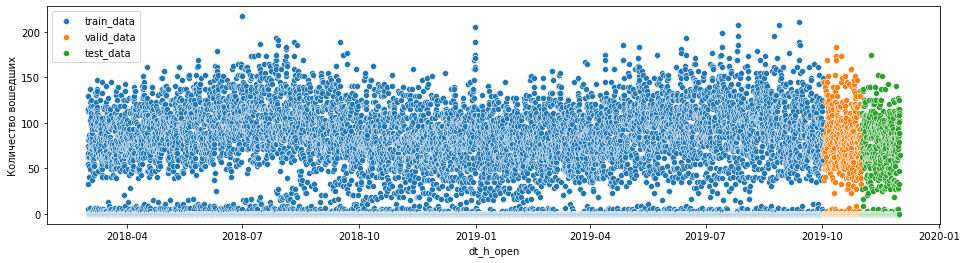

In [168]:
fig, ax = plt.subplots(figsize=(16,4))
sns.scatterplot(data=train_data, x="dt_h_open", y="Количество вошедших", ax=ax, label='train_data')
sns.scatterplot(data=valid_data, x="dt_h_open", y="Количество вошедших", ax=ax, label='valid_data')
sns.scatterplot(data=test_data, x="dt_h_open", y="Количество вошедших", ax=ax, label='test_data')

### Нахождение оптимальных гиперпараметров

In [189]:
xgb_params = {        
    'learning_rate': 0.1, 
    'max_depth': 6,
    'random_state': 27,
}

research_model = XGBRegressor(n_estimators=200, **xgb_params)
research_model = research_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, eval_metric=['mae'])

print(f"best_score: {research_model.best_score}, best_iteration: {research_model.best_iteration}")

[0]	validation_0-mae:43.66179
[1]	validation_0-mae:39.22568
[2]	validation_0-mae:35.16814
[3]	validation_0-mae:31.61778
[4]	validation_0-mae:28.45495
[5]	validation_0-mae:25.57022
[6]	validation_0-mae:22.99466
[7]	validation_0-mae:20.70932
[8]	validation_0-mae:18.81593
[9]	validation_0-mae:17.04851
[10]	validation_0-mae:15.45829
[11]	validation_0-mae:14.12763
[12]	validation_0-mae:13.04221
[13]	validation_0-mae:11.98376
[14]	validation_0-mae:11.11159
[15]	validation_0-mae:10.38795
[16]	validation_0-mae:9.76662
[17]	validation_0-mae:9.23519
[18]	validation_0-mae:8.76495
[19]	validation_0-mae:8.38544
[20]	validation_0-mae:8.05541
[21]	validation_0-mae:7.74181
[22]	validation_0-mae:7.44730
[23]	validation_0-mae:7.24428
[24]	validation_0-mae:7.03352
[25]	validation_0-mae:6.84692
[26]	validation_0-mae:6.68128
[27]	validation_0-mae:6.53644
[28]	validation_0-mae:6.43228
[29]	validation_0-mae:6.34172
[30]	validation_0-mae:6.26594
[31]	validation_0-mae:6.18279
[32]	validation_0-mae:6.10508
[33]

In [188]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=research_model.best_iteration, **xgb_params)

model.fit(X_train_valid, y_train_valid)
y_test_pred = model.predict(X_test)

model_score = check_score(y_test, y_test_pred)
print(f"Mean: {y_test.mean():.5f}")
print(f"Score: {model_score:.5f}")

Mean: 45.68194
Score: 4.66337


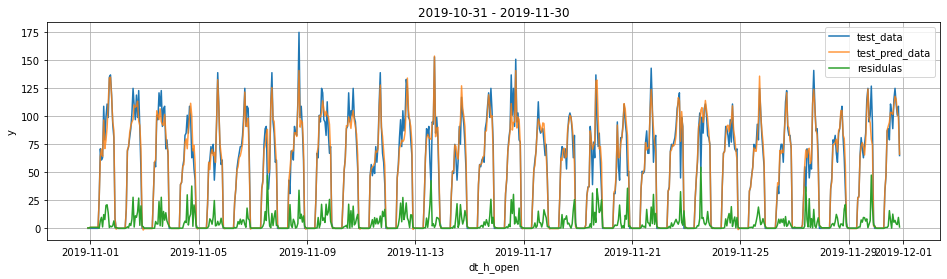

In [172]:
def plot_data_in_range(X_test, y_test, y_test_pred, st_date=None, end_date=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16,4))

    plot_data = X_test.copy()
    plot_data['y'] = y_test
    plot_data['y_pred'] = y_test_pred
    plot_data['residulas'] = abs(y_test_pred-y_test)
    
    if st_date is None:
        st_date = X_test.index[0].strftime("%Y-%m-%d")
    
    if end_date is None:
        end_date = X_test.index[-1].strftime("%Y-%m-%d")
        
    plot_data = plot_data[st_date:end_date]
    
    sns.lineplot(data=plot_data, x="dt_h_open", y='y', ax=ax, label='test_data')
    sns.lineplot(data=plot_data, x="dt_h_open", y='y_pred', ax=ax, label='test_pred_data', alpha=0.8)
    sns.lineplot(data=plot_data, x="dt_h_open", y='residulas', ax=ax, label='residulas')
    
    ax.set_title(f"{st_date} - {end_date}")
    ax.grid(True)
    

plot_data_in_range(X_test, y_test, y_test_pred, st_date = None, end_date = None)

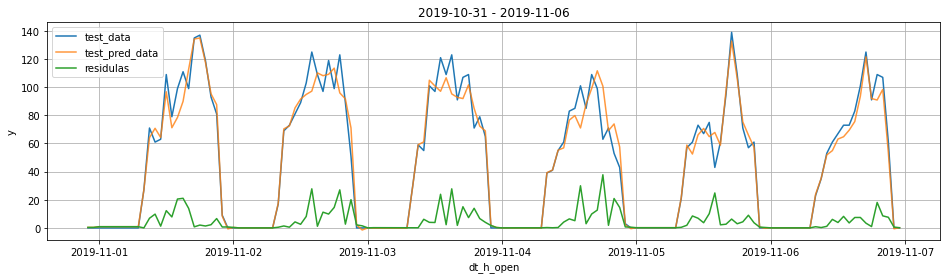

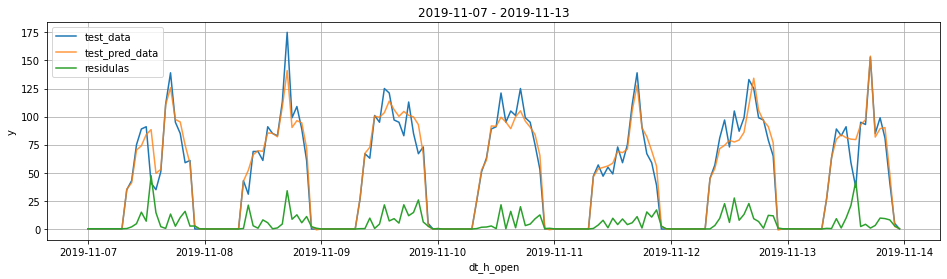

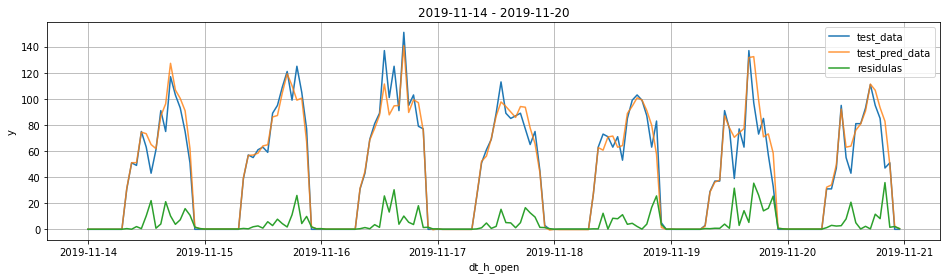

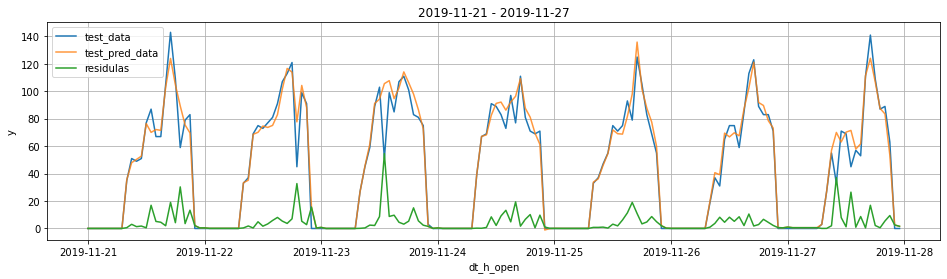

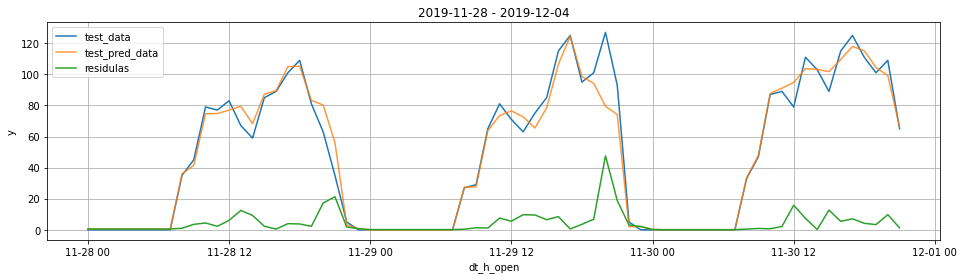

In [174]:
from datetime import timedelta

def plot_data_by_weeks(X_test, y_test, y_test_pred):
    st_date = X_test.index[0].date()
    
    while st_date < X_test.index[-1].date():
        st_date_str = st_date.strftime("%Y-%m-%d")
        end_date_str = (st_date+timedelta(days=6)).strftime("%Y-%m-%d")

        plot_data_in_range(X_test, y_test, y_test_pred, st_date = st_date_str, end_date = end_date_str)

        st_date += timedelta(days=7)

plot_data_by_weeks(X_test, y_test, y_test_pred)

In [104]:
from ipywidgets import interact, interactive, fixed, interact_manual

st_date = X_test.index[0]
end_date = X_test.index[-1]
dates_to_view = [date.strftime("%Y-%m-%d") for date in pd.date_range(start=st_date, end=end_date)]

@interact(date=dates_to_view)
def plot_date_interactive(date):
    plot_data_in_range(X_test, y_test, y_test_pred, date, date)

interactive(children=(Dropdown(description='date', options=('2019-10-31', '2019-11-01', '2019-11-02', '2019-11…

### Обучение модели на всем наборе данных

## 5. Результаты и выводы

## 6. Старое

In [ ]:
# all_df = {}

# train_df_by_shop = {}
# for name, data in train_df.groupby('Номер магазина'):
#     train_df_by_shop[name] = data
#     all_df["train_"+name] = data

# test_df_by_shop = {}
# for name, data in test_df.groupby('Номер магазина'):
#     test_df_by_shop[name] = data
#     all_df["test_"+name] = data
    
# train_df_alt = train_df_by_shop['Алтушка']
# train_df_alt.head()

# train_df_by_shop = {}
# for name, data in train_df.groupby('Номер магазина'):
#     train_df_by_shop[name] = data

In [ ]:
# test_df_alt = test_df_alt.set_index('dt_h_open').resample('1H').mean().sort_index()
# test_df_but = test_df_but.set_index('dt_h_open').resample('1H').mean().sort_index()

In [ ]:
# # df1.resample('1M').mean()

# df_3m = pd.DataFrame(index=pd.date_range(start='2019-12-01', periods=3, freq="1M"))

# df_alt_2y = train_df_alt.add(df_xxx, axis='index', fill_value=0).resample('1H').mean().fillna(0)
# df_but_2y = train_df_but.add(df_xxx, axis='index', fill_value=0).resample('1H').mean().fillna(0)



In [ ]:
# def interpolate_outliers(df, col_name):
#     p25 = np.percentile(df[col_name], 25)
#     p75 = np.percentile(df[col_name], 75)
#     iqr = p75 - p25
    
#     lower = p25 - 1.5*iqr
#     upper = p75 + 1.5*iqr
    
#     df[col_name] = df[col_name].where((df[col_name] > lower) & (df[col_name] < upper), other=np.nan)
#     df['outlier'] = df[col_name].isna()
#     df[col_name].interpolate(inplace=True)
    
# df_tmp = train_df_by_days_alt.copy()
# interpolate_outliers(df_tmp, "Количество вошедших")

In [ ]:
# def interpolate_outliers(df, col_name):
#     p25 = np.percentile(df[col_name], 25)
#     p75 = np.percentile(df[col_name], 75)
#     iqr = p75 - p25
    
#     lower = p25 - 1.5*iqr
#     upper = p75 + 1.5*iqr
    
#     df[col_name] = df[col_name].where((df[col_name] > lower) & (df[col_name] < upper), other=np.nan)
#     df['outlier'] = df[col_name].isna()
#     df[col_name].interpolate(inplace=True)
    
# df_tmp = train_df_by_days_alt.copy()
# interpolate_outliers(df_tmp, "Количество вошедших")